# Pygmalion - Projet autocomplétion

**Sprint 2 : modélisation #1**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DataScientest-Studio/Pygmalion/blob/main/notebooks/2-Modelisation_1.ipynb)

## 0. Création des classes

In [ ]:
class Email:
  """
  Used to stock emails
  Attributes
  ----------
  subject : str
    The text of the subject of the email
  content : str
    The text of the body of the email
  number : int
    The number of the email

  Methods
  -------
  get_word_count(subject=False)
    Return the number of word in the email content (in the subject if subject = True)
  get_token(regex="[A-Za-z]+", lowercase=True, subject=False)
    Email tokenization feature
  """

  def __init__(self, subject, content, number):
    """
    Parameters
    ----------
    subject : str
      The text of the subject of the email
    content : str
      The text of the body of the email
    number : int
      The number of the email
    """
    self.subject = subject
    self.content = content
    self.number = number

  def __repr__(self):
    return "Mail n°" + str(self.number)

  def __str__(self):
    return "Mail n°" + str(self.number) + " de " + str(len(self.content.split())) + " mots"

  def get_word_count(self, subject=False):
    """
    Return the number of word in the email content
    (in the subject if subject = True)
    """
    if subject:
      text = self.subject
    else:
      text = self.content
    return len(text.split())

  def get_token(self, regex="[A-Za-z]+", lowercase=True, subject=False):
    """ Fonction de tokenisation de l'email.
    Permet d'obtenir une liste de mot à partir du texte de l'email.
    :param regex: une version alternative du regex peut être renseigné.
    :param lowercase: si lowercase = True, les lettres seront
    transformé en minuscule.
    :param subject: si subject = True, le texte du sujet sera utilisé,
    sinon ce sera le corps de l'email.

    :return: Une liste contenant les mots nettoyé
    """
    tokenizer = RegexpTokenizer(regex)
    if subject:
      text = self.subject
    else:
      text = self.content
    if lowercase:
      return tokenizer.tokenize(text.lower())
    else:
      return tokenizer.tokenize(text)

In [ ]:
class Dataset:
  """
  Used to stock dataset
  Attributes
  ----------
  mails : Email
    A list of Emails

  Methods
  -------
  add_mails(emails)
    Add more emails to the dataset
  get_mail(number)
    Extract one email from dthe dataset by the mail number
  get_dict_mots(ngram=1, regex="[A-Za-z]+", lowercase=True, subject=False)
    Produces a dictionary containing the count of each sliced ngram with
    the specified attributes
  train_test_split(test_size=0.25, random_state=None)
    Split dataset into random train and test subsets
  """
  def __init__(self, mails=[]):
    self.mails = mails

  def __repr__(self):
    return "Dataset de " + str(len(self.mails)) + " mails"

  def __str__(self):
    return "Dataset de " + str(len(self.mails)) + " mails"
  
  def add_mails(self, emails):
    """
    Add more emails to the dataset
    Parameters
    ----------
    emails : List of Emails
    """
    self.mails.extend(emails) #Need to be a list of emails
  
  def get_mail(self, number):
    """
    Extract one email from the dataset by the mail number
    Parameters
    ----------
    number : int
    """
    try:
      return self.mails[number]
    except IndexError:
      print("Indice non valide")

  def get_dict_mots(self, ngram=1, regex="[A-Za-z]+", lowercase=True, subject=False):
    """
    Produces a dictionary containing the count of each sliced ngram with
    the specified attributes
    Parameters
    ----------
    ngram : int (optional)
      The number of contiguous sequence of n words.
    regex : str (optional)
      The regular expression, ie. the sequence of characters that specifies
      the search pattern in text
    lowercase : bool (optional)
      Convert string to lowercase
    subject : bool (optional)
      If True, data from subject will be used
    """
    dict_mots = {}
    with tqdm(total = len(self.mails)) as pbar: #Load a progress bar
      for mail in self.mails:
        pbar.update(1)
        tokens = mail.get_token(regex, lowercase, subject)
        # serialisation
        for word_i in range(ngram-1, len(tokens)):
          word = ""
          for a in range(-ngram+1,0):
            word += tokens[word_i+a]
            word += " "
          word += tokens[word_i]
          if word not in dict_mots:
            dict_mots[word] = 1
          else:
            dict_mots[word] += 1
      return dict_mots

  def train_test_split(self, test_size=0.25, random_state=None):
    """
    Split dataset into random train and test subsets
    Parameters
    ----------
    test_size : float (optional)
      The fraction of emails in the test dataset
    random_state : int (optional)
      Initialize the random number generator.
      If random_state is omitted or None, the current system time is used.
    """
    if random_state != None:
      random.seed(random_state)
    nombre_element_test = round(len(self.mails)*test_size)
    random.shuffle(self.mails)
    Dataset_train = Dataset(mails = self.mails[nombre_element_test:])
    Dataset_test = Dataset(mails = self.mails[:nombre_element_test])
    return Dataset_train, Dataset_test

In [ ]:
class Occurence:
  def __init__(self):
    self.fited = False
    self.prefix = ""

  def fit(self, Dataset, regex="[A-Za-z]+", lowercase=True, subject=False, frequence_min=0):
    dict_mots = Dataset.get_dict_mots(ngram = 1, regex = regex, lowercase = lowercase, subject = subject)
    df_words = df_word_from_dict(dict_mots)
    self.df_words = df_words[df_words["counts"]>frequence_min]
    self.fited = True
  
  def word_complete(self, first_letter, n_first_words=5):
    ''' Auto_completion routine r.1.1
        As argument
        - mot : (string), type the first letters you want to complete
        - text : reference text used as corpus
    '''
    start_with = self.df_words["words"].str.startswith(first_letter)
    return self.df_words.loc[start_with].head(n_first_words)

  def word_complete_plot(self, first_letter, n_first_words=5):
    words = self.word_complete(first_letter, n_first_words)
    if words.empty:
      print("Aucune suggéstion")
    else:
      plt.figure(figsize = (14,6))
      sns.barplot(y = words.words, x = words.counts)
      plt.title("Nbre de mots dans e-mails")
      plt.show()
  
  def score(self, tokens, n_first_words=1):
    score = 0
    letter_num = 0
    for word in tokens:
      prefix = ""
      letter_num += len(word)
      for i, letter in enumerate(word):
        prefix += letter
        guess = self.word_complete(prefix, n_first_words)
        if guess.empty:
          score += 0
          break
        else:
          if guess["words"].str.fullmatch(word).any():
            score += (len(word) - i)
            break
    return score, letter_num

In [ ]:
def df_word_from_dict(dict_mots):
  df_words = pd.Series(dict_mots, name = "counts").to_frame()
  df_words.insert(0, 'length', df_words.index.str.len())
  df_words = df_words.sort_values(by = 'counts', ascending=False).reset_index().rename(columns = {"index":"words"})
  return df_words

In [ ]:
class Ngram:
  """
  Words auto-completion by N-grams occurrence 
  Attributes
  ----------
  ngram : int
    Number of contiguous words to use by default for auto-completion queries,
    should be 1 or higher.
  fited : bool
    True when fitting have been done and prediction can be perfomed.

  Methods
  -------
  fit(Dataset, regex="[A-Za-z]+", lowercase=True, subject=False, frequence_min=0)
    Fit the words auto-completion by N-grams occurrence from the training dataset
  word_complete(first_letter, n_first_words=5)
    Auto_completion routine
  word_complete_plot(first_letter, n_first_words=5)
    Plot a bar plot from the auto_completion routine
  score(tokens, n_first_words=1)
    Return the score on the given test dataset
  """
  def __init__(self, ngram=2):
    self.ngram = ngram
    self.fited = False
    self.prefix = ""

  def fit(self, Dataset, regex="[A-Za-z]+", lowercase=True, subject=False, frequence_min=0):
    """
    Fit the words auto-completion by N-grams occurrence from the training dataset
    For all N-grams from 1 to ngram, the occurrence of each N-gram will be
    computed in the training Dataset and stored in a list of DataFrame df_words
    Parameters
    ----------
    Dataset : Dataset containing Emails
    regex : str (optional)
      The regular expression, ie. the sequence of characters that specifies
      the search pattern in text
    lowercase : bool (optional)
      Convert string to lowercase
    subject : bool (optional)
      If True, data from subject will be used
    frequence_min : int (optional)
      Minimum number of occurrences at which the N-gram must appear in the
      dataset to be kept in the occurrence DataFrame.
    """
    self.df_words = [None]*self.ngram # Empty list for all N-grams from 1 to ngram
    for i in range(0, self.ngram):
      dict_mots = Dataset.get_dict_mots(ngram =i+1, regex = regex, lowercase = lowercase, subject = subject)
      df_words = df_word_from_dict(dict_mots)
      self.df_words[i] = df_words[df_words["counts"]>frequence_min] # Deletes the rarest occurrences to reduce the model size
    self.fited = True

  def _word_complete_ngram(self, first_letter, ngram, n_first_words):
    start_time = time.time()
    startWith = self.df_words[ngram-1]["words"].str.startswith(first_letter)
    duration = time.time() - start_time
    result = self.df_words[ngram-1].loc[startWith].head(n_first_words)
    result["ngram_num"] = ngram
    result = result.rename(columns = {"words":"ngram"})
    listWord = result["ngram"].str.split(" ")
    result["word"] = [x[-1] for x in listWord]
    return result, duration
  
  def word_complete(self, first_letter, n_first_words=5):
    """
    Auto_completion routine
    Look for the most frequent n-grams that start with first_letter
    in the dictionary produced by fitting
    Parameters
    ----------
    first_letter : str
      First letters to complete
    n_first_words : int (optional)
      The maximum number of results the program will return
    """
    result = pd.DataFrame(columns = ["ngram", "length", "counts", "ngram_num", "word"])
    to_add = n_first_words # Initializes the number of results needed
    ngram = self.ngram # Initializes the number of n-grams
    duration = []
    while (to_add > 0):
      # Look for the most frequent n-grams that start with first_letter and
      # in the dictionary of size ngram
      temp, durationE = self._word_complete_ngram(first_letter, ngram, to_add)
      duration.append(durationE)
      result = result.append(temp)
      # Compute the number of n-gram still needed
      to_add = n_first_words - len(result.index)
      if ngram <1: # Can't compute for n-gram < 1 word
        break
      # Remove the 1st word from the first_letter variable and reduce ngram by 1
      first_letter = first_letter.split(" ",1)[-1]
      ngram -= 1
    return result, np.mean(duration)

  def word_complete_plot(self, first_letter, n_first_words=5):
    """
    Plot a bar plot from the auto_completion routine
    Parameters
    ----------
    first_letter : str
      First letters to complete
    n_first_words : int (optional)
      The maximum number of results the program will return
    """
    words = self.word_complete(first_letter, n_first_words)
    if words.empty:
      print("Aucune suggéstion")
    else:
      plt.figure(figsize = (14,6))
      sns.barplot(y = words.word, x = words.counts)
      plt.title("Nbre de mots dans e-mails")
      plt.show()
  
  def score(self, tokens, n_first_words=1):
    """
    Return the score on the given test dataset
    Parameters
    ----------
    token : list of str
      First letters to complete
    n_first_words : int (optional)
      The maximum number of results the program will use to compute score
    """
    score = 0
    letter_num = 0
    previous_word = [""]*(self.ngram-1) # Initialize the list of previous words
    duration = []
    for num_word, word in enumerate(tokens):
      if self.ngram>1:
        # Make the prefix that will be used according to the following format:
        # word1 + " " + ... + wordn + " "
        prefix = " ".join(previous_word)
        prefix += " "
        prefix = prefix.lstrip()
        # Removes the oldest previous word and add the current word for the next iteration
        del previous_word[0]
        previous_word.append(word)
      else:
        # if self.ngram = 1, there is no prefix
        prefix = ""
      # The score cannot be calculated for the first words.
      # For example, for the sentence "Here is our forecast" and an n-gram of 3,
      # the program starts calculating the score from "our".
      if num_word >= (self.ngram-1):
        letter_num += len(word) # Increment the total number of letters by the word size
        for i, letter in enumerate(word):
          prefix += letter # Add the current letter to the prefix
          guess, durationE = self.word_complete(prefix, n_first_words) # Auto_completion routine
          duration.append(durationE)
          if guess.empty:
            # If no result is found with a short word, it is impossible for a
            # result to be found with a longer word beginning with the same letters.
            # The score is not increased and the for loop for the word is stopped.
            break
          else:
            # If a result is found, we look if any of them are the word we are looking for.
            if guess["word"].str.fullmatch(word).any():
              # The score is increased by the size of the word minus the position
              # in the word (0 for the first letter, 1 for the second, etc.)
              # the for loop for the word is stopped.
              # We can choose to use score += (len(word) - i - 1)
              # to be at 0 when the word is finished. Score will be lower!
              score += (len(word) - i)
              break
    return score, letter_num, np.mean(duration)

## I. Chargement des données et preprocessing

Montage du disque et import des packages

In [ ]:
# Import des packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
from nltk.tokenize.regexp import RegexpTokenizer
from tqdm.notebook import tqdm
import random

In [ ]:
# Necessaire pour sauvegarder les données sur google drive (Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Indiquez le dossier de sauvegarde de vos fichiers
path = '/content/drive/MyDrive/Pygmalion/'

Chargement du Dataset ENRON

In [ ]:
# Chargement du dataframe à partir de google drive
# Le dataset est préparé dans le fichier 1-Exploration_des_données_et_DataViz
df_emails = pd.read_csv(path+'df_emails.csv')

In [ ]:
# Création du Dataset simplifié pour test
start_time = time.time()
ENRON = Dataset([Email(df_emails.loc[i].Subject, df_emails.loc[i].content, i) for i in range(1000)])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.6042401790618896 seconds ---


In [ ]:
# Création du Dataset ENRON complet : prends environ 3 mins
start_time = time.time()
ENRON = Dataset([Email(df_emails.loc[i].Subject, df_emails.loc[i].content, i) for i in range(df_emails.shape[0])])
print("--- %s seconds ---" % (time.time() - start_time))


--- 146.9097776412964 seconds ---


Compilation des mots et leur nombre d'apparitions

In [ ]:
dict_mots = ENRON.get_dict_mots()
print("Le Dataset nettoyé contient", len(dict_mots), "mots")
df_words = pd.Series(dict_mots, name = "counts").to_frame()
df_words.insert(0, 'length', df_words.index.str.len())
df_words = df_words.sort_values(by = 'counts', ascending = False).reset_index().rename(columns = {"index":"words"})

  0%|          | 0/517401 [00:00<?, ?it/s]

Le Dataset nettoyé contient 222848 mots


## II. Axes d'analyse


### 1. Par occurrence: aucune prise en compte de l’environnement

**Problématique** : Nous commençons par une approche d'auto-complétion très simple, ou nous devinons le prochain mot par occurrence, sans prise en compte de l’environnement du mot.
Nous devons mettre en place plusieurs étapes :
*	Calculer l’occurrence de chaque mot dans le corpus
*	Etablir une proba d’apparition du mot
*	Trouver les mots avec la plus forte probabilité

In [ ]:
occurence_ENRON = Occurence()
occurence_ENRON.fit(ENRON, frequence_min = 10)

  0%|          | 0/517401 [00:00<?, ?it/s]

In [ ]:
occurence_ENRON.word_complete("th", n_first_words = 5)

,words,length,counts
0,the,3,4836587
10,that,4,888738
13,this,4,715785
51,they,4,198316
64,their,5,156292


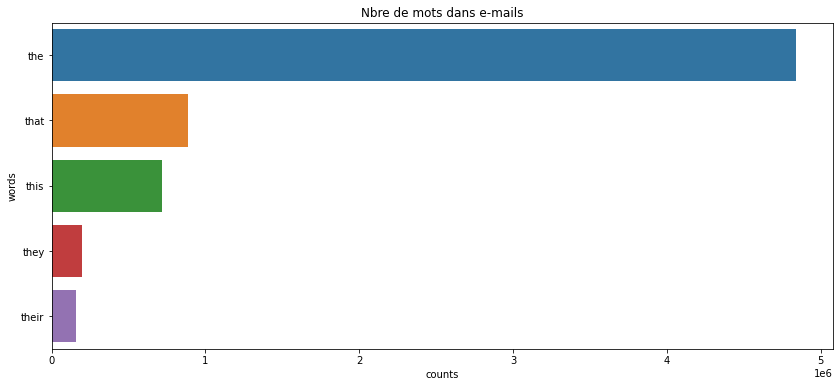

In [ ]:
occurence_ENRON.word_complete_plot("th", n_first_words = 5)

**Commentaire** : Nous sommes capables de trouver les n-mots les plus probable en fonction des lettres tapées par l’utilisateur.

Nous devons maintenant mesurer l’efficacité de nos prédictions. Pour cela, nous avons développé une fonction de scoring qui mesure le nombre d’appuis clavier économisé. Par exemple, si on veut taper la phrase « hello there»,  un générateur simulera l’appuis successif sur les touches « h », « e », « l »,  « l », « o », « », « t », « h », « e », « r », « e », etc.

Après chaque appui, nous essayerons de deviner le ou les n-mots, et à la fin du mot, nous mesurons combien de fois le mot à été présenté et le nombre de lettre.


#### Nous calculons le score pour les 20 premiers emails du Dataset.

In [ ]:
start_time = time.time()
score_total = []
letter_total = []
with tqdm(total = 20) as pbar:
  for i in range(20):
    pbar.update(1)
    tokens = ENRON.get_mail(i).get_token()
    score, letter = occurence_ENRON.score(tokens, 1)
    score_total.append(score)
    letter_total.append(letter)

print("--- %s seconds ---" % (time.time() - start_time))
# Le temps de calcul est très long ( 30s par email)

  0%|          | 0/20 [00:00<?, ?it/s]

--- 351.47297739982605 seconds ---


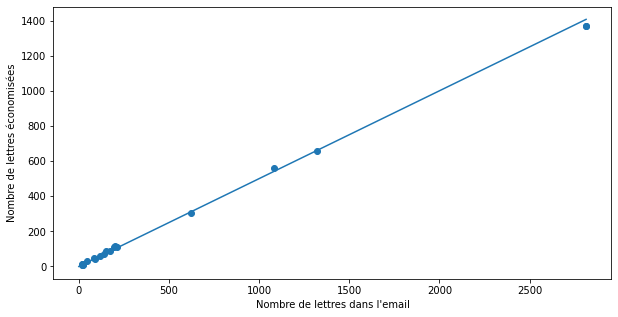

Le score moyen du Dataset est de : 50.073768073177924 %


In [ ]:
scoreMoyen = sum(score_total)/sum(letter_total)

plt.figure(figsize = (10,5))

plt.plot([0, max(letter_total)], [0, scoreMoyen*max(letter_total)])
plt.scatter(y = score_total, x = letter_total)

plt.xlabel("Nombre de lettres dans l'email")
plt.ylabel("Nombre de lettres économisées")
plt.show()

print("Le score moyen du Dataset est de :", 100*scoreMoyen, "%")
# On voit que le pourcentage de lettre économisé est très similaire dans chaque emails.

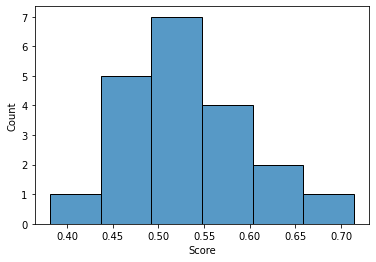

In [ ]:
score_df = pd.DataFrame(np.array([score_total, letter_total]).T, columns=['Saved Letter','Total letter'])

score_df["Score"] = score_df['Saved Letter'] / score_df['Total letter']

score_df = score_df.dropna()

sns.histplot(data = score_df, x = "Score")
# Certains emails ont un score qui diverge significativement du score moyen.

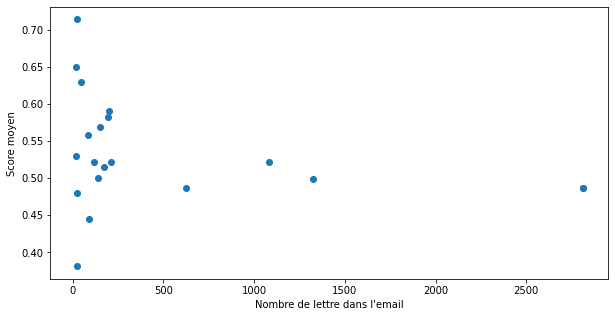

In [ ]:
plt.figure(figsize = (10,5))


plt.scatter(y = score_df["Score"], x = score_df['Total letter'])

plt.xlabel("Nombre de lettre dans l'email")
plt.ylabel("Score moyen")
plt.show()
# Toutefois, on peut remarquer que le score diverge significativement seulement pour les mails les plus courts.

**Commentaire** : Nous sommes capables d'économiser environ 50% des appuis sur le clavier avec une approche aussi simple.

### 2. Par occurence: prise en compte d'informations sur l’environnement du mot

#### Génération des n-grammes (1 à 3)
> - on souhaite mesuré l'impact en temps pour générer les n-grammes
>- vérifier l'impact sur la performance en termes de vitesse et de scoring (capacité à trouver le bon mot avec un minimum de saisie de lettres)

> Nous allons générer les 3 dataframes ngram3_fxx.df_words[0] à ngram5_fxx.df_words[4] associés aux filtres suivants: 
>- f0 (ensemble des mots), 
>- f10 (mots comptés plus de 10x), 
>- f50 (mots comptés plus de 50x) et 
>- f100 (mots comptés plus de 100x)

In [ ]:
t1 = []
start_time = time.time()
print("Création du modèle avec un ngram de 1 sur la totalité des mots du corpus")
ngram1_f0 = Ngram(ngram = 1)
ngram1_f0.fit(ENRON)
t1.append(time.time() - start_time)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
print("Création du modèle avec un ngram de 1 sur les mots comptés plus de 10x dans le corpus")
ngram1_f10 = Ngram(ngram = 1)
ngram1_f10.fit(ENRON, frequence_min = 10)
t1.append(time.time() - start_time)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
print("Création du modèle avec un ngram de 1, fsur les mots comptés plus de 50x dans le corpus")
ngram1_f50 = Ngram(ngram = 1)
ngram1_f50.fit(ENRON, frequence_min = 50)
t1.append(time.time() - start_time)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
print("Création du modèle avec un ngram de 1, fsur les mots comlptés plus de 100x dans le corpus")
ngram1_f100 = Ngram(ngram = 1)
ngram1_f100.fit(ENRON, frequence_min = 100)
t1.append(time.time() - start_time)
print("--- %s seconds ---" % (time.time() - start_time))

Création du modèle avec un ngram de 1 sur la totalité des mots du corpus


  0%|          | 0/517401 [00:00<?, ?it/s]

--- 99.32345056533813 seconds ---
Création du modèle avec un ngram de 1 sur les mots comptés plus de 10x dans le corpus


  0%|          | 0/517401 [00:00<?, ?it/s]

--- 98.93980240821838 seconds ---
Création du modèle avec un ngram de 1, fsur les mots comptés plus de 50x dans le corpus


  0%|          | 0/517401 [00:00<?, ?it/s]

--- 102.92727971076965 seconds ---
Création du modèle avec un ngram de 1, fsur les mots comlptés plus de 100x dans le corpus


  0%|          | 0/517401 [00:00<?, ?it/s]

--- 99.62568020820618 seconds ---


In [ ]:
t2 = []
start_time = time.time()
print("Création du modèle avec un ngram de 2 sur la totalité des mots du corpus")
ngram2_f0 = Ngram(ngram = 2)
ngram2_f0.fit(ENRON)
t2.append(time.time() - start_time)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
print("Création du modèle avec un ngram de 2 sur les mots comptés plus de 10x dans le corpus")
ngram2_f10 = Ngram(ngram = 2)
ngram2_f10.fit(ENRON, frequence_min = 10)
t2.append(time.time() - start_time)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
print("Création du modèle avec un ngram de 2, sur les mots comptés plus de 50x dans le corpus")
ngram2_f50 = Ngram(ngram = 2)
ngram2_f50.fit(ENRON, frequence_min = 50)
t2.append(time.time() - start_time)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
print("Création du modèle avec un ngram de 2, fsur les mots comlptés plus de 100x dans le corpus")
ngram2_f100 = Ngram(ngram = 2)
ngram2_f100.fit(ENRON, frequence_min = 100)
t2.append(time.time() - start_time)
print("--- %s seconds ---" % (time.time() - start_time))

Création du modèle avec un ngram de 2 sur la totalité des mots du corpus


  0%|          | 0/517401 [00:00<?, ?it/s]

  0%|          | 0/517401 [00:00<?, ?it/s]

--- 275.0809953212738 seconds ---
Création du modèle avec un ngram de 2 sur les mots comptés plus de 10x dans le corpus


  0%|          | 0/517401 [00:00<?, ?it/s]

  0%|          | 0/517401 [00:00<?, ?it/s]

--- 272.2372040748596 seconds ---
Création du modèle avec un ngram de 2, fsur les mots comptés plus de 50x dans le corpus


  0%|          | 0/517401 [00:00<?, ?it/s]

  0%|          | 0/517401 [00:00<?, ?it/s]

--- 270.90057253837585 seconds ---
Création du modèle avec un ngram de 2, fsur les mots comlptés plus de 100x dans le corpus


  0%|          | 0/517401 [00:00<?, ?it/s]

  0%|          | 0/517401 [00:00<?, ?it/s]

--- 270.7963252067566 seconds ---


In [ ]:
t3 = []
start_time = time.time()
print("Création du modèle avec un ngram de 3 sur la totalité des mots du corpus")
ngram3_f0 = Ngram(ngram = 3)
ngram3_f0.fit(ENRON)
t3.append(time.time() - start_time)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
print("Création du modèle avec un ngram de 3 sur les mots comptés plus de 10x dans le corpus")
ngram3_f10 = Ngram(ngram = 3)
ngram3_f10.fit(ENRON, frequence_min = 10)
t3.append(time.time() - start_time)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
print("Création du modèle avec un ngram de 3, fsur les mots comptés plus de 50x dans le corpus")
ngram3_f50 = Ngram(ngram = 3)
ngram3_f50.fit(ENRON, frequence_min = 50)
t3.append(time.time() - start_time)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
print("Création du modèle avec un ngram de 3, fsur les mots comlptés plus de 100x dans le corpus")
ngram3_f100 = Ngram(ngram = 3)
ngram3_f100.fit(ENRON, frequence_min = 100)
t3.append(time.time() - start_time)
print("--- %s seconds ---" % (time.time() - start_time))

Création du modèle avec un ngram de 3 sur la totalité des mots du corpus


  0%|          | 0/517401 [00:00<?, ?it/s]

  0%|          | 0/517401 [00:00<?, ?it/s]

  0%|          | 0/517401 [00:00<?, ?it/s]

--- 494.4478714466095 seconds ---
Création du modèle avec un ngram de 3 sur les mots comptés plus de 10x dans le corpus


  0%|          | 0/517401 [00:00<?, ?it/s]

  0%|          | 0/517401 [00:00<?, ?it/s]

  0%|          | 0/517401 [00:00<?, ?it/s]

--- 461.7160975933075 seconds ---
Création du modèle avec un ngram de 3, fsur les mots comptés plus de 50x dans le corpus


  0%|          | 0/517401 [00:00<?, ?it/s]

  0%|          | 0/517401 [00:00<?, ?it/s]

  0%|          | 0/517401 [00:00<?, ?it/s]

--- 484.4991307258606 seconds ---
Création du modèle avec un ngram de 3, fsur les mots comlptés plus de 100x dans le corpus


  0%|          | 0/517401 [00:00<?, ?it/s]

  0%|          | 0/517401 [00:00<?, ?it/s]

  0%|          | 0/517401 [00:00<?, ?it/s]

--- 510.52677607536316 seconds ---


> Les temps de génération des 3 n-grams est indépendant de la valeur du filtre. Ce qui est normal, puisque le filtre est pris en compte lors de l'écriture du dataframe final. L'impact sera mesurable en temps de réponse lors de la recherche des mots et au niveau du scoring. C'est ce que nous allons voir dans la suite de cette étude afin de déterminer le meilleur compromis filtre/performance.

> Taille des différents dataframes en fonction du filtre

In [ ]:
ngramf0Lignes=[]
ngramf10Lignes=[]
ngramf50Lignes=[]
ngramf100Lignes=[]
for i in range(3):
    ngramf0Lignes.append(len(ngram3_f0.df_words[i]))
    ngramf10Lignes.append(len(ngram3_f10.df_words[i]))
    ngramf50Lignes.append(len(ngram3_f50.df_words[i]))
    ngramf100Lignes.append(len(ngram3_f100.df_words[i]))

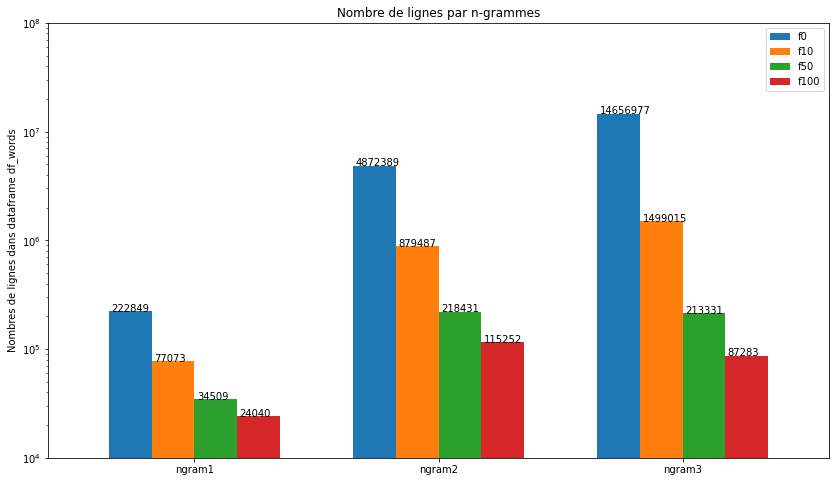

In [ ]:
#ngramf0Lignes=[222848, 4872388, 14656976]
#ngramf10Lignes=[77072, 879486, 1499014]
#ngramf50Lignes=[34508, 218430, 213330]
#ngramf100Lignes=[24039, 115251, 87282]

ngramList=['ngram1','ngram2','ngram3']
dicLines={'f0':(ngramf0Lignes),
    'f10':(ngramf10Lignes),
    'f50':(ngramf50Lignes),
    'f100':(ngramf100Lignes)}

df=pd.DataFrame(dicLines,index=ngramList)
ax=df.plot.bar(figsize=(14,8), log=True, ylabel='Nombres de lignes dans dataframe df_words', width=0.7)

plt.xticks(rotation = 0)


for p in ax.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1)        
    ax.annotate(val, (b.x0+0.01, b.y1))
    
plt.legend()
plt.ylim(10000,1e8)
plt.title('Nombre de lignes par n-grammes')
plt.show()

#### Temps de réponse et scoring
> Deux test seront réalisés pour évaluer la performance de nos différents modèles
>- Temps de réponse à la recherche d'un préfixe respectivement parmi les unigrammes, bigrammes et trigrammes
>- Mesure du score (économie de saisie du texte) sur un email test, puis sur un échantillon de 20 mails.

Mail test = premier mail du Dataset  ENRON

In [ ]:
tokens = ENRON.get_mail(0).get_token()
print(tokens)

['here', 'is', 'our', 'forecast']


> Il s'agit d'un texte très court (17 lettres au total), pour ce premier test.


In [ ]:
# Test sur unigrammes
score, lettre, duration1_f0 = ngram1_f0.score(tokens, 1)
score, lettre, duration1_f10 = ngram1_f10.score(tokens, 1)
score, lettre, duration1_f50 = ngram1_f50.score(tokens, 1)
score, lettre, duration1_f100 = ngram1_f100.score(tokens, 1)

# Test sur bigrammes
score, lettre, duration2_f0 = ngram2_f0.score(tokens, 1)
score, lettre, duration2_f10 = ngram2_f10.score(tokens, 1)
score, lettre, duration2_f50 = ngram2_f50.score(tokens, 1)
score, lettre, duration2_f100 = ngram2_f100.score(tokens, 1)

# Test sur trigrammes
score, lettre, duration3_f0 = ngram3_f0.score(tokens, 1)
score, lettre, duration3_f10 = ngram3_f10.score(tokens, 1)
score, lettre, duration3_f50 = ngram3_f50.score(tokens, 1)
score, lettre, duration3_f100 = ngram3_f100.score(tokens, 1)

durationf0=[duration1_f0, duration2_f0,duration3_f0]
durationf10=[duration1_f10, duration2_f10,duration3_f10]
durationf50=[duration1_f50, duration2_f50,duration3_f50]
durationf100=[duration1_f100, duration2_f100,duration3_f100]

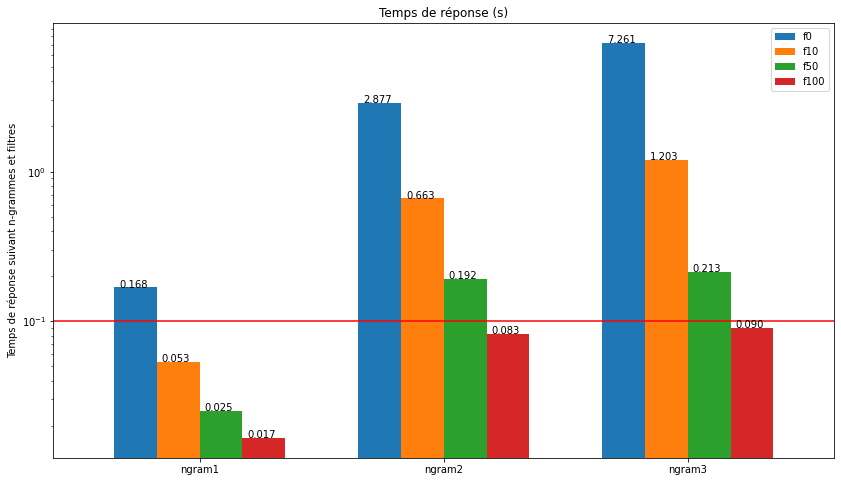

In [ ]:
#durationf0 = [0.11851511398951213, 3.3445656980787004, 6.873558282852173]
#durationf10 = [0.039442976315816246, 0.8630008016313825, 0.9931726694107056]
#durationf50 = [0.015520215034484863, 0.1547084195273263, 0.16571354866027832]
#durationf100 = [0.010628839333852133, 0.07213833928108215, 0.06358910269207425]
ngramList=['ngram1','ngram2','ngram3']
dicDuration={'f0':(durationf0),
    'f10':(durationf10),
    'f50':(durationf50),
    'f100':(durationf100)}

df=pd.DataFrame(dicDuration,index=ngramList)
ax=df.plot.bar(figsize=(14,8), log=True, ylabel='Temps de réponse suivant n-grammes et filtres', width=0.7)

for p in ax.patches:
    b = p.get_bbox()
    val = "{:.3f}".format(b.y1)        
    ax.annotate(val, (b.x0+0.02 , b.y1))
plt.xticks(rotation = 0)
plt.xticks(rotation = 0)
plt.axhline(y=0.1, c='r')
plt.legend()
plt.title('Temps de réponse (s)')
plt.show()

> Ce test permet d'éliminer l'utilisation du Dataset complet. Les temps de réponses sont bien trop longs.Seuls les filtres >50 ou >100 semblent pouvoir répondre à un fonctionnement fluide de motre modèle.

> Test de ces deux configurations sur les 20 premiers mails du Dataset ENRON

In [ ]:
start_time = time.time()
nbrDeMail = 20
score1_f50_total = []
letter1_f50_total = []
duration1_f50_total = []
score2_f50_total = []
letter2_f50_total = []
duration2_f50_total = []
score3_f50_total = []
letter3_f50_total = []
duration3_f50_total = []



with tqdm(total=3*nbrDeMail) as pbar:
  for i in range(nbrDeMail):
    tokens = ENRON.get_mail(i).get_token()

    pbar.update(1)
    score1_f50, letter1_f50, duration1_f50 = ngram1_f50.score(tokens, 1)
    score1_f50_total.append(score1_f50)
    letter1_f50_total.append(letter1_f50)
    duration1_f50_total.append(duration1_f50)

    pbar.update(1)
    score2_f50, letter2_f50, duration2_f50 = ngram2_f50.score(tokens, 1)
    score2_f50_total.append(score2_f50)
    letter2_f50_total.append(letter2_f50)
    duration2_f50_total.append(duration2_f50)

    pbar.update(1)
    score3_f50, letter3_f50, duration3_f50 = ngram3_f50.score(tokens, 1)
    score3_f50_total.append(score3_f50)
    letter3_f50_total.append(letter3_f50)
    duration3_f50_total.append(duration3_f50)

print("--- %s seconds ---" % (time.time() - start_time))


  0%|          | 0/60 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


--- 3223.9315099716187 seconds ---


In [ ]:
start_time = time.time()
nbrDeMail = 20
score1_f100_total = []
letter1_f100_total = []
duration1_f100_total = []
score2_f100_total = []
letter2_f100_total = []
duration2_f100_total = []
score3_f100_total = []
letter3_f100_total = []
duration3_f100_total = []



with tqdm(total=3*nbrDeMail) as pbar:
  for i in range(nbrDeMail):
    tokens = ENRON.get_mail(i).get_token()

    pbar.update(1)
    score1_f100, letter1_f100, duration1_f100 = ngram1_f100.score(tokens, 1)
    score1_f100_total.append(score1_f100)
    letter1_f100_total.append(letter1_f100)
    duration1_f100_total.append(duration1_f100)

    pbar.update(1)
    score2_f100, letter2_f100, duration2_f100 = ngram2_f100.score(tokens, 1)
    score2_f100_total.append(score2_f100)
    letter2_f100_total.append(letter2_f100)
    duration2_f100_total.append(duration2_f100)

    pbar.update(1)
    score3_f100, letter3_f100, duration3_f100 = ngram3_f100.score(tokens, 1)
    score3_f100_total.append(score3_f100)
    letter3_f100_total.append(letter3_f100)
    duration3_f100_total.append(duration3_f100)

print("--- %s seconds ---" % (time.time() - start_time))

  0%|          | 0/60 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


--- 1699.603230714798 seconds ---


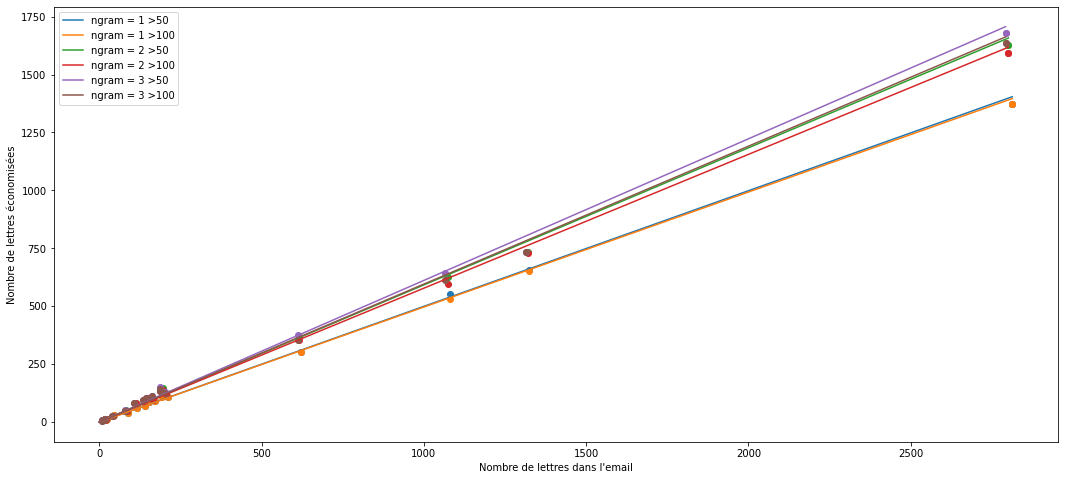

Le score moyen du dataset sans contexte est de : 49.916396183731685 % calculé en  0.021744380936197953 s par opération
Le score moyen du dataset avec le mot précédent est de : 59.17312661498708 % calculé en  0.15401091379046566 s par opération


Le score moyen du dataset sans contexte est de : 49.631159634110354 % calculé en  0.01445421909432452 s par opération
Le score moyen du dataset avec le mot précédent est de : 57.76187636652753 % calculé en  0.07140027664251589 s par opération


Le score moyen du dataset avec 2 mots précédents est de : 59.530026109660575 % calculé en  0.07092598982063049 s par opération


In [ ]:


plt.figure(figsize=(18,8))
scoreMoyen1_f50 = sum(score1_f50_total)/sum(letter1_f50_total)
plt.plot([0, max(letter1_f50_total)], [0, scoreMoyen1_f50*max(letter1_f50_total)], label="ngram = 1 >50")
plt.scatter(y = score1_f50_total, x = letter1_f50_total)

scoreMoyen1_f100 = sum(score1_f100_total)/sum(letter1_f100_total)
plt.plot([0, max(letter1_f100_total)], [0, scoreMoyen1_f100*max(letter1_f100_total)], label="ngram = 1 >100")
plt.scatter(y = score1_f100_total, x = letter1_f100_total)



scoreMoyen2_f50 = sum(score2_f50_total)/sum(letter2_f50_total)
plt.plot([0, max(letter2_f50_total)], [0, scoreMoyen2_f50*max(letter2_f50_total)], label="ngram = 2 >50")
plt.scatter(y = score2_f50_total, x = letter2_f50_total)

scoreMoyen2_f100 = sum(score2_f100_total)/sum(letter2_f100_total)
plt.plot([0, max(letter2_f100_total)], [0, scoreMoyen2_f100*max(letter2_f100_total)], label="ngram = 2 >100")
plt.scatter(y = score2_f100_total, x = letter2_f100_total)

scoreMoyen3_f50 = sum(score3_f50_total)/sum(letter3_f50_total)
plt.plot([0, max(letter3_f50_total)], [0, scoreMoyen3_f50*max(letter3_f50_total)], label="ngram = 3 >50")
plt.scatter(y = score3_f50_total, x = letter3_f50_total)

scoreMoyen3_f100 = sum(score3_f100_total)/sum(letter3_f100_total)
plt.plot([0, max(letter3_f100_total)], [0, scoreMoyen3_f100*max(letter3_f100_total)], label="ngram = 3 >100")
plt.scatter(y = score3_f100_total, x = letter3_f100_total)

plt.xlabel("Nombre de lettres dans l'email")
plt.ylabel("Nombre de lettres économisées")
plt.legend()
plt.show()

print("Le score moyen du dataset sans contexte est de :", 100*scoreMoyen1_f50, "% calculé en ", np.mean(duration1_f50_total), "s par opération")
print("Le score moyen du dataset avec le mot précédent est de :", 100*scoreMoyen2_f50, "% calculé en ", np.mean(duration2_f50_total), "s par opération")
print("\n")
print("Le score moyen du dataset sans contexte est de :", 100*scoreMoyen1_f100, "% calculé en ", np.mean(duration1_f100_total), "s par opération")
print("Le score moyen du dataset avec le mot précédent est de :", 100*scoreMoyen2_f100, "% calculé en ", np.mean(duration2_f100_total), "s par opération")
print("\n")
print("Le score moyen du dataset avec 2 mots précédents est de :", 100*scoreMoyen3_f100, "% calculé en ", np.mean(duration3_f100_total), "s par opération")


# On voit que le pourcentage de lettre économisé est très similaire dans chaque emails.

> En conclusion,<br>
>- on note sur ce graphe, que le score 49,6% pour un filtre >100 reste comparable avec celui du filtre >50, 49,9%, à comparer au score sans filtre de 50,0%.
>- le score obtenu en prenant compte du mot précédent est sensiblement meilleur 59% Vs. 49% soit un gain de 20%
le temps de réponse par contre est 1,5 fois meilleur pour le filtre >100
>- A suivre l'étude sur la base d'un trigramme et d'un seuil encore plus important.
>- le temps de calcul pour obtenir le score est de 35mn. On atteint ici les limites de ce modèle "trivial". On pourra continuer à optimiser la programmation, le seuil du filtre pour amélorer ce modèle, mais les gains resteront faibles par rapport aux résultats de cette étude. Il est nécessaire de changer totalement d'approche pour construire un système d'auto-completion performant.


In [ ]:
start_time = time.time()
print("Création du modèle avec un ngram de 3, fsur les mots comlptés plus de 500x dans le corpus")
ngram3_f500 = Ngram(ngram = 3)
ngram3_f500.fit(ENRON, frequence_min = 500)
print("--- %s seconds ---" % (time.time() - start_time))

Création du modèle avec un ngram de 3, fsur les mots comlptés plus de 500x dans le corpus


  0%|          | 0/517401 [00:00<?, ?it/s]

  0%|          | 0/517401 [00:00<?, ?it/s]

  0%|          | 0/517401 [00:00<?, ?it/s]

--- 486.8049991130829 seconds ---


In [ ]:
start_time = time.time()
nbrDeMail = 20

score3_f500_total = []
letter3_f500_total = []
duration3_f500_total = []




with tqdm(total = nbrDeMail) as pbar:
  for i in range(nbrDeMail):
    tokens = ENRON.get_mail(i).get_token()
    
    pbar.update(1)
    tokens = ENRON.get_mail(i).get_token()
    score3_f500, letter3_f500, duration3_f500 = ngram3_f500.score(tokens, 1)
    score3_f500_total.append(score3_f500)
    letter3_f500_total.append(letter3_f500)
    duration3_f500_total.append(duration3_f500)    

print("--- %s seconds ---" % (time.time() - start_time))



  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


--- 230.38100337982178 seconds ---


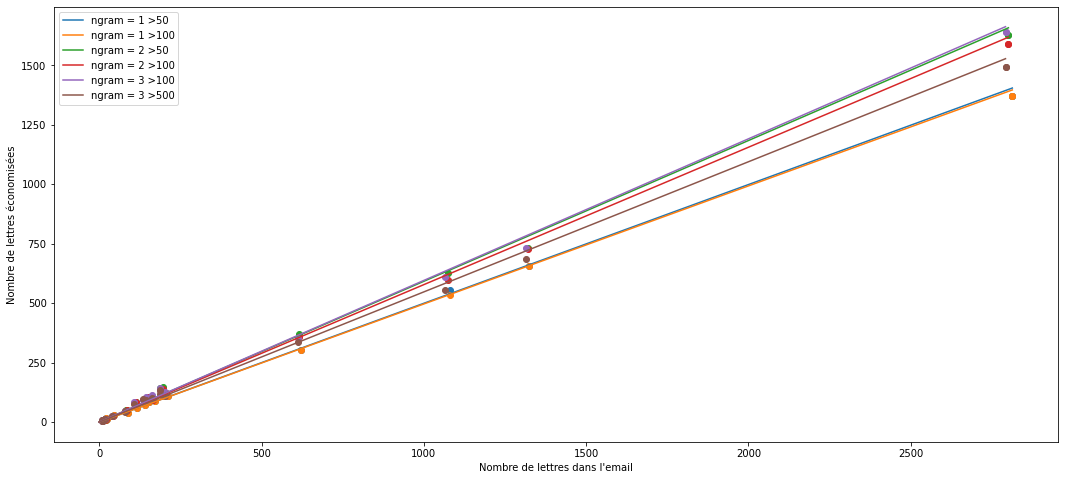

Le score moyen du Dataset sans contexte (>50) est de : 49.916396183731685 % calculé en  0.021744380936197953 s par opération
Le score moyen du Dataset avec le mot précédent (>50) est de : 59.17312661498708 % calculé en  0.15401091379046566 s par opération


Le score moyen du Dataset sans contexte (>100) est de : 49.631159634110354 % calculé en  0.01445421909432452 s par opération
Le score moyen du Dataset avec le mot précédent (>100) est de : 57.76187636652753 % calculé en  0.07140027664251589 s par opération


Le score moyen du Dataset avec 2 mots précédents (>100) est de : 59.530026109660575 % calculé en  0.07092598982063049 s par opération
Le score moyen du Dataset avec 2 mots précédents (>500) est de : 54.70978108053826 % calculé en  0.012442336420107086 s par opération


In [ ]:


plt.figure(figsize=(18,8))
scoreMoyen1_f50 = sum(score1_f50_total)/sum(letter1_f50_total)
plt.plot([0, max(letter1_f50_total)], [0, scoreMoyen1_f50*max(letter1_f50_total)], label = "ngram = 1 >50")
plt.scatter(y = score1_f50_total, x = letter1_f50_total)

scoreMoyen1_f100 = sum(score1_f100_total)/sum(letter1_f100_total)
plt.plot([0, max(letter1_f100_total)], [0, scoreMoyen1_f100*max(letter1_f100_total)], label = "ngram = 1 >100")
plt.scatter(y = score1_f100_total, x = letter1_f100_total)



scoreMoyen2_f50 = sum(score2_f50_total)/sum(letter2_f50_total)
plt.plot([0, max(letter2_f50_total)], [0, scoreMoyen2_f50*max(letter2_f50_total)], label = "ngram = 2 >50")
plt.scatter(y = score2_f50_total, x = letter2_f50_total)

scoreMoyen2_f100 = sum(score2_f100_total)/sum(letter2_f100_total)
plt.plot([0, max(letter2_f100_total)], [0, scoreMoyen2_f100*max(letter2_f100_total)], label = "ngram = 2 >100")
plt.scatter(y = score2_f100_total, x = letter2_f100_total)

scoreMoyen3_f100 = sum(score3_f100_total)/sum(letter3_f100_total)
plt.plot([0, max(letter3_f100_total)], [0, scoreMoyen3_f100*max(letter3_f100_total)], label = "ngram = 3 >100")
plt.scatter(y = score3_f100_total, x = letter3_f100_total)

scoreMoyen3_f500 = sum(score3_f500_total)/sum(letter3_f500_total)
plt.plot([0, max(letter3_f500_total)], [0, scoreMoyen3_f500*max(letter3_f500_total)], label = "ngram = 3 >500")
plt.scatter(y = score3_f500_total, x = letter3_f500_total)

plt.xlabel("Nombre de lettres dans l'email")
plt.ylabel("Nombre de lettres économisées")
plt.legend()
plt.show()

print("Le score moyen du Dataset sans contexte (>50) est de :", 100*scoreMoyen1_f50, "% calculé en ", np.mean(duration1_f50_total), "s par opération")
print("Le score moyen du Dataset avec le mot précédent (>50) est de :", 100*scoreMoyen2_f50, "% calculé en ", np.mean(duration2_f50_total), "s par opération")
print("\n")
print("Le score moyen du Dataset sans contexte (>100) est de :", 100*scoreMoyen1_f100, "% calculé en ", np.mean(duration1_f100_total), "s par opération")
print("Le score moyen du Dataset avec le mot précédent (>100) est de :", 100*scoreMoyen2_f100, "% calculé en ", np.mean(duration2_f100_total), "s par opération")
print("\n")
print("Le score moyen du Dataset avec 2 mots précédents (>100) est de :", 100*scoreMoyen3_f100, "% calculé en ", np.mean(duration3_f100_total), "s par opération")
print("Le score moyen du Dataset avec 2 mots précédents (>500) est de :", 100*scoreMoyen3_f500, "% calculé en ", np.mean(duration3_f500_total), "s par opération")




> Le score est inférieur de 8%, mais est toutefois meilleur de 9% que le score obtenu sur la base d'unigrammes sur l'ensemble des mots du dataset. Le gain de temps par rapport du filtre >500 par rapport au filtre >100 est de 7,5 fois.

### Effet des mots pluriels Vs. singuliers

> Nous allons réaliser cette étude sur les cas de pluriels 'simples', les noms terminés par la lettre 's'. Ce sont les cas les plus défavorables, puisque un mot de longeur n, souvent détecté à la saisie des premières lettres doit être saisi dans le cas de son pluriel jusqu'à la dernière lettre. Pour éviter de modifier des mots comme "business", "as" nous allons au préaliable vérifier le tag du mot. S'il est de type NNS, nous éliminerons la lettre 's'.

> Pour détecter les mots se terminant par la lettre 's' nous allons utiliser un regex qui supprimera la lettre 's' en fin de mot.

In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

> Modification de la fonction score() pour transformer les noms pluriels en noms singuliers

In [ ]:
def score_singular(self, tokens, n_first_words=1):
  score = 0
  letter_num = 0
  previous_word = [""]*(self.ngram-1)
  duration = []
  for num_word, word in enumerate(tokens):
    tags=nltk.pos_tag(word_tokenize(word))
    if tags[0][1]=='NNS':            # si word du type NNS (nom au pluriel)
        word=r.findall(word)[0][0]   # transformation pluriel / singulier
    if self.ngram>1:
      prefix = " ".join(previous_word)
      prefix += " "
      prefix = prefix.lstrip()

      del previous_word[0]
      previous_word.append(word)
    else:
      prefix = ""
    if num_word >= (self.ngram-1):
      letter_num += len(word)
      for i, letter in enumerate(word):
        prefix += letter
        guess, durationE = self.word_complete(prefix, n_first_words)
        duration.append(durationE)
        if guess.empty:
          score += 0
          break
        else:
          if guess["word"].str.fullmatch(word).any():
            score += (len(word) - i)
            break
  return score, letter_num, np.mean(duration)


Ngram.score_singular = score_singular

In [ ]:
start_time = time.time()
nbrDeMail = 20
score3_f500_total = []
letter3_f500_total = []
duration3_f500_total = []




with tqdm(total = nbrDeMail) as pbar:
  for i in range(nbrDeMail):
    
    pbar.update(1)
    tokens = ENRON.get_mail(i).get_token()
    score3_f500, letter3_f500, duration3_f500 = ngram3_f500.score_singular(tokens, 1)
    score3_f500_total.append(score3_f500)
    letter3_f500_total.append(letter3_f500)
    duration3_f500_total.append(duration3_f500)    

print("--- %s seconds ---" % (time.time() - start_time))

  0%|          | 0/20 [00:00<?, ?it/s]

--- 225.3265676498413 seconds ---


In [ ]:
scoreMoyen3_f500 = sum(score3_f500_total)/sum(letter3_f500_total)

In [ ]:
print("Le score moyen du Dataset avec 2 mots précédents (>500) est de :", 100*scoreMoyen3_f500, "% calculé en ", np.mean(duration3_f500_total), "s par opération")

Le score moyen du Dataset avec 2 mots précédents (>500) est de : 56.54305853509041 % calculé en  0.011966400405727745 s par opération


> Cette simple opération nous a permis de gagner 2 points en terme de performance sans réel impact sur le temps de traitement.

### Performance du modèle suivant la taille des mots

Nous allons enregistrer dans la fonction score le score en fonction de la longueur du mot dans une liste scoreVsLen, puis tracer un graphique de la moyenne des scores obtenus meanSscoreVsLen en fonction de la longueur des mots.

> Modification de la fonction score()

In [ ]:
def score_len(self, tokens, n_first_words=1):
  score = 0
  letter_num = 0
  previous_word = [""]*(self.ngram-1)
  duration = []
  for num_word, word in enumerate(tokens):
    tags=nltk.pos_tag(word_tokenize(word))
    if tags[0][1]=='NNS':            # si word du type NNS (nom au pluriel)
        word=r.findall(word)[0][0]   # transformation pluriel / singulier
    if self.ngram>1:
      prefix = " ".join(previous_word)
      prefix += " "
      prefix = prefix.lstrip()

      del previous_word[0]
      previous_word.append(word)
    else:
      prefix = ""
    if num_word >= (self.ngram-1):
      letter_num += len(word)
      for i, letter in enumerate(word):
        prefix += letter
        guess, durationE = self.word_complete(prefix, n_first_words)
        duration.append(durationE)
        if guess.empty:
          score += 0
          break
        else:
          if guess["word"].str.fullmatch(word).any():
            score += (len(word) - i)
            scoreVsLen[len(word)].append(len(word)-i)    # enregistrement du score / mot
            break
  return score, letter_num, np.mean(duration), scoreVsLen


Ngram.score_len = score_len

In [ ]:
start_time = time.time()
nbrDeMail = 20
scoreVsLen = []
for i in range(1,15):
    scoreVsLen.append([])
score3_f500_total = []
letter3_f500_total = []
duration3_f500_total = []




with tqdm(total = nbrDeMail) as pbar:
  for i in range(nbrDeMail):
    
    pbar.update(1)
    tokens = ENRON.get_mail(i).get_token()
    score3_f500, letter3_f500, duration3_f500, scoreVsLen = ngram3_f500.score_len(tokens, 1)
    score3_f500_total.append(score3_f500)
    print(scoreVsLen, flush=True)
    letter3_f500_total.append(letter3_f500)
    duration3_f500_total.append(duration3_f500)    

print("--- %s seconds ---" % (time.time() - start_time))

  0%|          | 0/20 [00:00<?, ?it/s]

[[], [], [], [2], [], [], [], [], [4], [], [], [], [], []]
[[], [1, 1, 1, 1, 1, 1, 1], [2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1], [2, 2, 1, 3, 3, 3, 2, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 1], [4, 2, 4, 4, 2, 1, 3, 2, 3, 4, 2, 3, 4, 4, 3, 4, 2, 1, 1, 2, 1, 4, 3], [1, 4, 4, 5, 5, 4, 4, 3, 2, 5, 2, 2, 3, 3, 3, 2, 1], [1, 3, 4, 5, 2, 4, 3], [5, 4, 7, 3, 5, 3, 5, 5, 5, 1, 5, 6, 3, 6], [4, 7, 7, 6, 7], [7, 1, 3], [9, 2, 3, 3], [], [8], []]
[[], [1, 1, 1, 1, 1, 1, 1], [2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1], [2, 2, 1, 3, 3, 3, 2, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 1, 1], [4, 2, 4, 4, 2, 1, 3, 2, 3, 4, 2, 3, 4, 4, 3, 4, 2, 1, 1, 2, 1, 4, 3], [1, 4, 4, 5, 5, 4, 4, 3, 2, 5, 2, 2, 3, 3, 3, 2, 1], [1, 3, 4, 5, 2, 4, 3], [5, 4, 7, 3, 5, 3, 5, 5, 5, 1, 5, 6, 3, 6], [4, 7, 7, 6, 7], [7, 1, 3], [9, 2, 3, 3], [], [8], []]
[[], [1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[[], [1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1], [2, 2, 1, 3, 3, 3, 2, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3], [4, 2, 4, 4, 2, 1, 3, 2, 3, 4, 2, 3, 4, 4, 3, 4, 2, 1, 1, 2, 1, 4, 3, 4, 2, 1, 2, 3, 4, 2, 4, 2, 2, 2, 2, 4, 4], [1, 4, 4, 5, 5, 4, 4, 3, 2, 5, 2, 2, 3, 3, 3, 2, 1, 3, 4, 2, 2, 4, 5, 5, 5, 3, 5, 1, 5], [1, 3, 4, 5, 2, 4, 3, 3, 5], [5, 4, 7, 3, 5, 3, 5, 5, 5, 1, 5, 6, 3, 6, 6, 3, 6, 6, 3, 3, 7, 7, 3, 3], [4, 7, 7, 6, 7, 7, 3, 6, 8], [7, 1, 3, 9], [9, 2, 3, 3, 3], [], [8, 9], []]
[[], [1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1], [2, 2, 1, 3, 3, 3, 2, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3], [4, 2, 4, 4, 2, 1, 3, 2, 3, 4, 2, 3, 4, 4, 3, 4, 2, 1, 1, 2, 1, 4, 3, 4, 2, 1, 2, 3, 4, 2, 4, 2, 2, 2, 2, 4,

In [ ]:
meanScoreVsLen=[]
for i in range(1,14):
    meanScoreVsLen.append((100*np.mean(scoreVsLen[i])/i).round(2))
print(meanScoreVsLen)

[100.0, 81.9, 81.89, 64.66, 62.49, 62.92, 60.4, 62.17, 57.29, 47.1, 69.7, 65.28, 36.92]


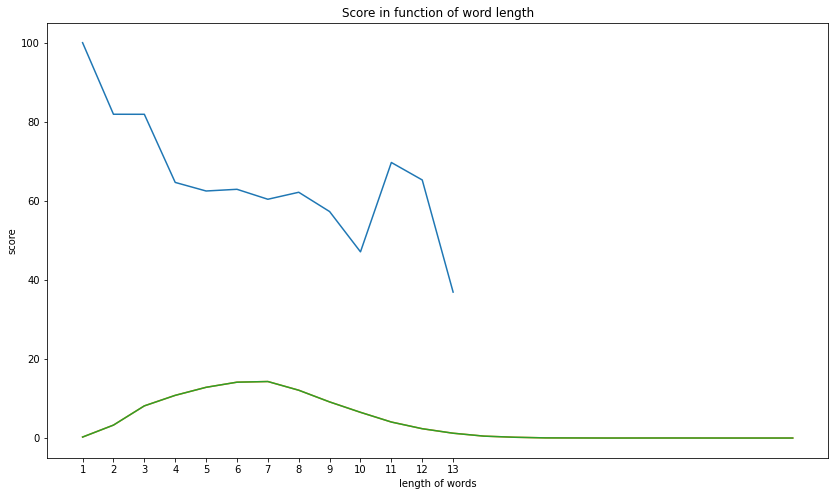

In [ ]:
x=range(1,14,1)
y=meanScoreVsLen
plt.figure(figsize=(14,8))
plt.plot(x, y)
plt.xticks(x)
plt.title('Score in function of word length')
plt.xlabel('length of words')
plt.ylabel('score')
plt.plot(100*ngram3_f500.df_words[0].groupby('length').count()/ngram3_f500.df_words[0].shape[0])
plt.show()



> Logiquement, le score diminue de manière quasi-linéaire avec la longueur des mots. Il y a cependant un niveau de performance plus élevé à partir des mots de 11 et 12 lettres. Ceci s'explique par le nombre plus faible de mots de cette longueur dans notre dictionaire de mots.(Courbe verte)

### Effet de la ponctation et des majuscules

In [ ]:
print("Création du modèle de base (sans majuscule et sans ponctuation) avec un ngram de 2")
ngram2_f50 = Ngram(ngram = 2)
ngram2_f50.fit(ENRON, regex="[A-Za-z]+", lowercase=True, subject=False, frequence_min=50)

print("Création du modèle avec un ngram de 2, avec majuscule et sans ponctuation")
ngram2_f50_maj = Ngram(ngram = 2)
ngram2_f50_maj.fit(ENRON, regex="[A-Za-z]+", lowercase=False, subject=False, frequence_min=50)

print("Création du modèle avec un ngram de 2, sans majuscule et avec ponctuation")
ngram2_f50_punct = Ngram(ngram = 2)
ngram2_f50_punct.fit(ENRON, regex="[A-Za-z,?;.:!()\-_+=\"']+", lowercase=True, subject=False, frequence_min=50)

print("Création du modèle avec un ngram de 2, avec majuscule et avec ponctuation")
ngram2_f50_maj_punct = Ngram(ngram = 2)
ngram2_f50_maj_punct.fit(ENRON, regex="[A-Za-z,?;.:!()\-_+=\"']+", lowercase=False, subject=False, frequence_min=50)

Création du modèle de base (sans majuscule et sans ponctuation) avec un ngram de 2


  0%|          | 0/517401 [00:00<?, ?it/s]

  0%|          | 0/517401 [00:00<?, ?it/s]

Création du modèle avec un ngram de 2, avec majuscule et sans ponctuation


  0%|          | 0/517401 [00:00<?, ?it/s]

  0%|          | 0/517401 [00:00<?, ?it/s]

Création du modèle avec un ngram de 2, sans majuscule et avec ponctuation


  0%|          | 0/517401 [00:00<?, ?it/s]

  0%|          | 0/517401 [00:00<?, ?it/s]

Création du modèle avec un ngram de 2, avec majuscule et avec ponctuation


  0%|          | 0/517401 [00:00<?, ?it/s]

  0%|          | 0/517401 [00:00<?, ?it/s]

In [ ]:
def get_df_word_size(dataset):
  return [df.shape[0] for df in dataset.df_words]
ngram2_f50_df_words_size = get_df_word_size(ngram2_f50)
ngram2_f50_maj_word_size = get_df_word_size(ngram2_f50_maj)

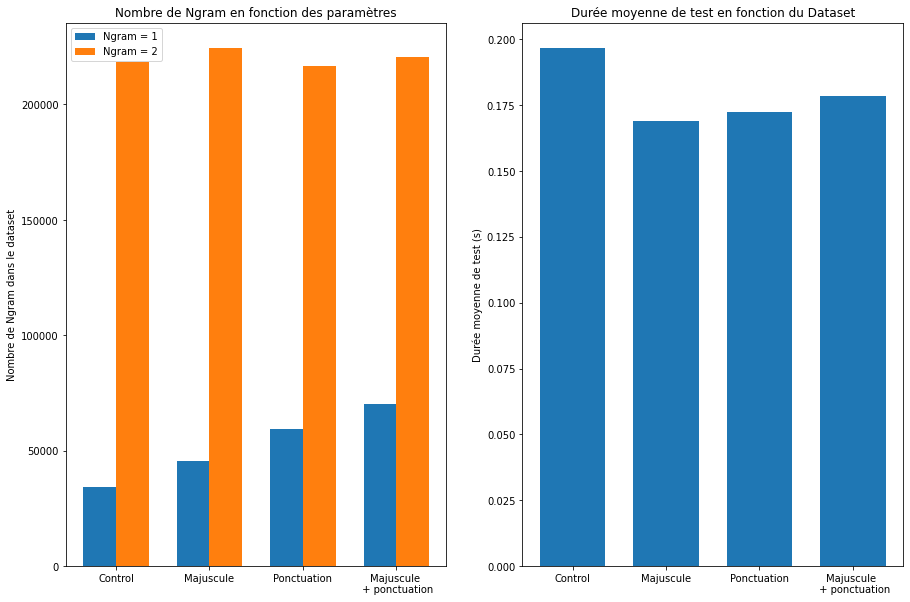

In [ ]:
data = [ngram2_f50, ngram2_f50_maj, ngram2_f50_punct, ngram2_f50_maj_punct]
labels = ["Control", "Majuscule", "Ponctuation", "Majuscule \n + ponctuation"]
width = 0.35

ngram_numbers = []
for dataset in data:
  ngram_numbers.append(get_df_word_size(dataset))

numpy_array = np.array(ngram_numbers)
transpose = numpy_array.T
ngram_numbers = transpose.tolist()



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
x = np.arange(len(labels))

ax1.bar(x - width/2, ngram_numbers[0], width, label='Ngram = 1')
ax1.bar(x + width/2, ngram_numbers[1], width, label='Ngram = 2')

ax1.set_ylabel('Nombre de Ngram dans le dataset')
ax1.set_title('Nombre de Ngram en fonction des paramètres')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)


ax1.legend()

tokens = ENRON.get_mail(0).get_token()
duration = []
for dataset in data:
  score, lettre, duration_temp = dataset.score(tokens, 1)
  duration.append(duration_temp)

ax2.bar(x, duration, 0.7)


ax2.set_ylabel('Durée moyenne de test (s)')
ax2.set_title('Durée moyenne de test en fonction du Dataset')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)


plt.show()


On voit que le fait d'ajouter des majuscule, de la ponctuation ou les deux ne change pas significativement le nombre d'entré dans le dictionnaire ou le temps de calculs.

In [ ]:
start_time = time.time()
nbrDeMail = 20
score_list = []
letter_list = []
duration_list = []
with tqdm(total = nbrDeMail*len(data)) as pbar:
  for i in range(nbrDeMail):
    tokens = ENRON.get_mail(i).get_token()
    for dataset in data:
      pbar.update(1)
      score, letter, duration = dataset.score(tokens, 1)
      score_list.append(score)
      letter_list.append(letter)
      duration_list.append(duration)

  0%|          | 0/80 [00:00<?, ?it/s]

In [ ]:
score_list = [[score_list[i+j*4] for j in range(int(len(score_list)/4))] for i in range(4)]
letter_list = [[letter_list[i+j*4] for j in range(int(len(letter_list)/4))] for i in range(4)]
duration_list = [[duration_list[i+j*4] for j in range(int(len(duration_list)/4))] for i in range(4)]

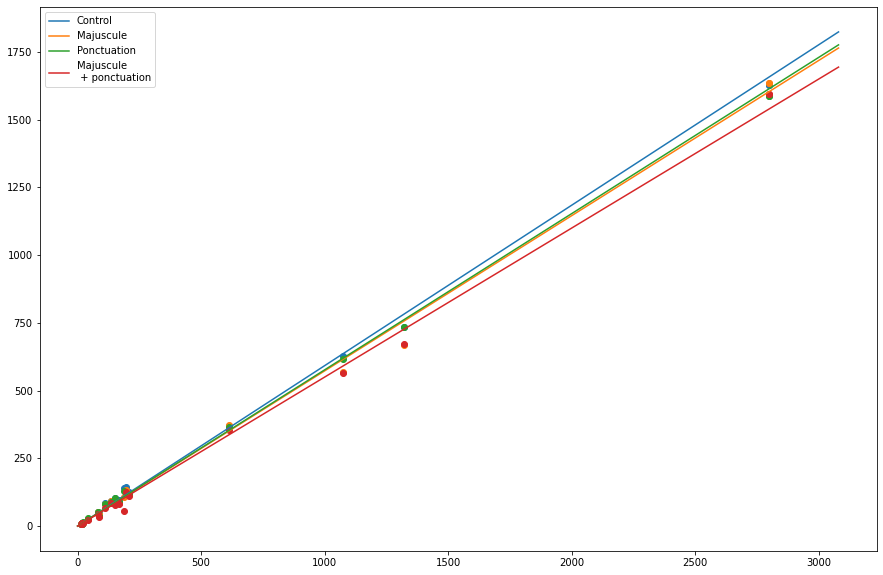

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
for i in range(len(labels)):
  score_moyen = sum(score_list[i])/sum(letter_list[i])
  ax.scatter(y = score_list[i], x = letter_list[i])
  ax.plot([0, 1.1*max(letter_list[i])], [0, 1.1*score_moyen*max(letter_list[i])], label = labels[i])
ax.legend()

plt.show()



In [ ]:
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

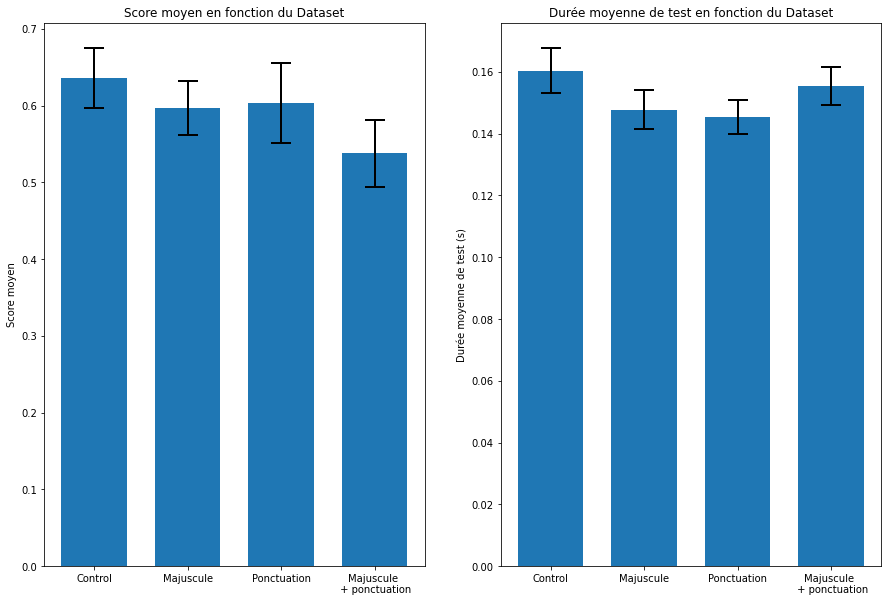

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
x = np.arange(len(labels))

mean_score = []
CI_score = []
mean_duration = []
CI_duration = []
for i in range(len(score_list)):
  score_temp = []
  for j in range(len(score_list[i])):
    score_temp.append(score_list[i][j]/letter_list[i][j])
  (mean, CI) = mean_confidence_interval(score_temp, confidence=0.95)  
  mean_score.append(mean)
  CI_score.append(CI)

  (mean, CI) = mean_confidence_interval(duration_list[i], confidence=0.95)
  mean_duration.append(mean)
  CI_duration.append(CI)

ax1.bar(x, mean_score, 0.7)
ax1.errorbar(x, mean_score, yerr=CI_score, fmt=' ', color="k", elinewidth = 2, capsize = 10, capthick = 2)

ax1.set_ylabel('Score moyen')
ax1.set_title('Score moyen en fonction du Dataset')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)


ax2.bar(x, mean_duration, 0.7)
ax2.errorbar(x, mean_duration, yerr=CI_duration, fmt=' ', color="k", elinewidth = 2, capsize = 10, capthick = 2)


ax2.set_ylabel('Durée moyenne de test (s)')
ax2.set_title('Durée moyenne de test en fonction du Dataset')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)


plt.show()

On voit que les scores ne sont pas significativement meilleurs quand on ajoute les majuscule ou la ponctuation. Ils ont même tendence à légèrement baisser. La durée n'est quand à elle presque pas impacté.